## Коэффициенты

In [2]:
!date
!pwd

Пн янв 14 05:27:35 MSK 2019
/home/alena/SPHERE/Data2018/Data/2018_12_07-08_run2/spectrum


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import dates
import datetime as dt

plt.rcParams['figure.figsize'] =(8,4)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 12

# Дифференциальный спектр

In [4]:
''' прочитать diff спектр '''
diff = pd.read_csv('./diff/diff70-120.csv', index_col=0)
print(len(diff))

dirprefix = './diff/diff'
names = ['0-10','10-20','20-40','40-50','50-60','60-70']
for i in range(len(names)):
    filename = dirprefix + names[i] + '.csv'
    diffn = pd.read_csv(filename, index_col=0)

    for chan in diff.columns[:]:
        diff[chan] += diffn[chan]

1000


In [5]:
''' чтение номеров событий '''
pied = pd.read_csv('piedestal01.csv', index_col=0)
print(len(pied))
pied.tail(2)

2122


,EID,I_coef,p0_1,p1_1,p0_2,p1_2,p0_3,p1_3,p0_4,p1_4,...,p0_53,p1_53,p0_56,p1_56,p0_57,p1_57,p0_60,p1_60,p0_61,p1_61
2120,28785,0.971455,50.0,48.0,50.0,47.5,49.0,50.0,49.0,46.0,...,49.0,54.0,51.5,59.0,49.5,48.0,48.0,52.5,50.0,57.0
2121,28787,0.971455,51.0,48.0,49.0,47.5,49.0,48.0,50.0,46.5,...,49.0,55.0,51.0,60.0,49.5,48.0,47.0,52.0,51.0,57.0


In [6]:
startevent,stopevent = 120,2122

dirprefix = './diff/diff.'
for i in range(startevent, pied.shape[0]):
    filename = dirprefix + str(pied.EID[i]) + '.csv'
    diffn = pd.read_csv(filename, index_col=0)

    for chan in diff.columns[:]:
        diff[chan] += diffn[chan]

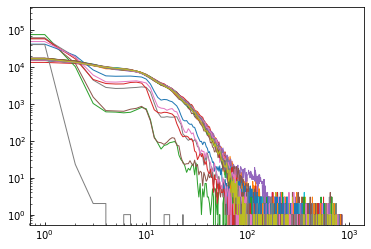

In [7]:
for chan in [str(x) for x in diff.columns[:]]:
    plt.plot(diff[chan])
plt.xscale('log')
plt.yscale('log')

In [8]:
diff.to_csv('diff.csv')

## Интегральный спектр

In [9]:
## make integral spectrum      
integral = pd.DataFrame()
for chan in diff.columns[:]:
    integral[chan] = diff[chan].sum() - diff[chan].cumsum()   

In [10]:
integral.to_csv('integral.csv')

In [11]:
#integral.columns
#integral

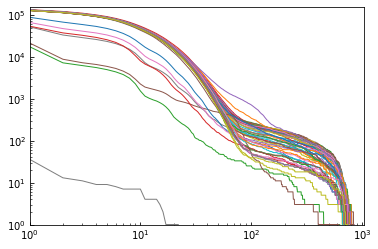

In [12]:
''' Интегральный спектр '''
for chan in integral.columns[:]:
    plt.plot(integral[chan])
plt.xlim(1)
plt.ylim(1)
plt.xscale('log')
plt.yscale('log')

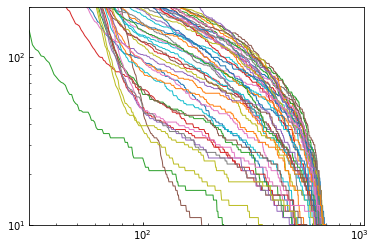

In [13]:
''' Интегральный спектр c органичениями по осям'''
for chan in integral.columns[:]:
    plt.plot(integral[chan])
plt.xlim(30)
plt.ylim(10,200)
plt.xscale('log')
plt.yscale('log')

In [14]:
''' списки обычных каналов и каналов с фильтрами '''
filters = ['23','26','28','31','34','37','40']
cols = list(integral.columns)
print(len(cols))
for x in filters:
    cols.remove(x)
print(len(cols))

49
42


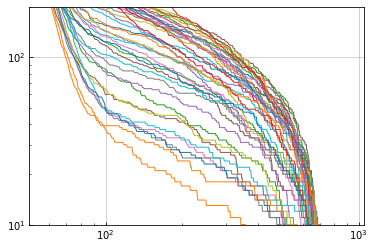

In [15]:
''' обычные каналы '''
for chan in cols:
    plt.plot(integral[chan]) #,label=str(chan))
plt.xlim(50)
plt.ylim(10,200)
plt.xscale('log')
plt.yscale('log')
plt.grid()

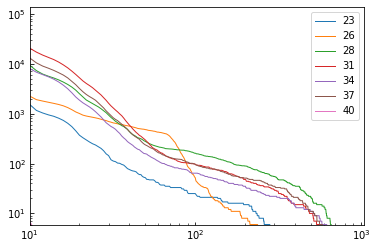

In [16]:
''' отличающиеся каналы '''
for chan in filters:
    plt.plot(integral[chan],label=str(chan))
plt.xlim(10)
plt.ylim(6)
plt.legend()
plt.xscale('log')
plt.yscale('log')

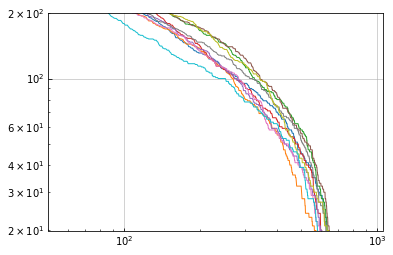

In [17]:
''' первые 10 каналов '''
for chan in cols[:10]:
    plt.plot(integral[chan]) #,label=str(chan))
plt.xlim(50)
plt.ylim(20,200)
#plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()

### Средний спектр

In [18]:
# считаем средний спектр по обычным каналам
print(integral.shape[0])
for i in range(integral.shape[0]):
    integral.loc[i,'average10'] = integral.loc[i,cols[:10]].sum()/len(cols[:10])
    integral.loc[i,'average']   = integral.loc[i,cols].sum()/len(cols)
#integral['average']

1000


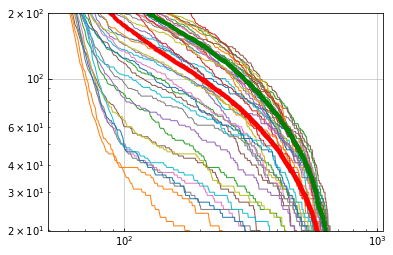

In [19]:
for chan in cols[:]:
    plt.plot(integral[chan], label=None)
    pass
plt.plot(integral.average,   'ro', label = 'aver', linewidth=2)
plt.plot(integral.average10, 'go', label = 'aver', linewidth=2)
plt.xlim(50)
plt.ylim(20,200)
plt.xscale('log')
plt.yscale('log')
plt.grid()

## Расчет коэффициентов

Отбросим области амплитуд менее 10 и более 200 событий на бин. По средней амплитуде найдем коэффициент поглощения черенковского света.

In [20]:
# отбросим области менее 10 и более 200 событий на бин
ampmax = 200
ampl = pd.DataFrame()
for n in integral.columns[:]:
    for i in range(integral.shape[0]-1):
        #print(i, integral.loc[i,n], end = '= ')
        if (integral.loc[i,n] >= 10) and (integral.loc[i+1,n] < 10):
            ampl.loc[n,'a10'] = i
        if (integral.loc[i,n] >= ampmax) and (integral.loc[i+1,n] < ampmax):
            ampl.loc[n,'a200'] = i
    # средняя амплитуда в каналах         
    ampl.loc[n,'amean'] = (ampl.loc[n,'a10'] + ampl.loc[n,'a200']) * 0.5
#ampl

In [21]:
# считаем коэффициенты относительно среднего спектра
for n in ampl.index:
    ampl.loc[n,'kch']   = ampl.loc[n,'amean'] / ampl.loc['average','amean'] 
    ampl.loc[n,'kch10'] = ampl.loc[n,'amean'] / ampl.loc['average10','amean'] 
    ampl.loc[n,'k10']  = ampl.loc[n,'a10']  / ampl.loc['average10','a10'] 
    ampl.loc[n,'k200'] = ampl.loc[n,'a200'] / ampl.loc['average10','a200'] 
    ampl.loc[n,'delta10']  = abs(ampl.loc[n,'k10'] - ampl.loc[n,'kch'])
    ampl.loc[n,'delta200'] = abs(ampl.loc[n,'kch'] - ampl.loc[n,'k200'])

In [22]:
ampl

,a200,a10,amean,kch,kch10,k10,k200,delta10,delta200
1,118.0,705.0,411.5,1.115176,1.039141,1.055389,0.951613,0.059787,0.163563
2,112.0,657.0,384.5,1.042005,0.970960,0.983533,0.903226,0.058472,0.138780
3,150.0,678.0,414.0,1.121951,1.045455,1.014970,1.209677,0.106981,0.087726
4,133.0,673.0,403.0,1.092141,1.017677,1.007485,1.072581,0.084656,0.019560
5,120.0,665.0,392.5,1.063686,0.991162,0.995509,0.967742,0.068177,0.095944
6,150.0,673.0,411.5,1.115176,1.039141,1.007485,1.209677,0.107691,0.094501
7,110.0,651.0,380.5,1.031165,0.960859,0.974551,0.887097,0.056614,0.144069
8,124.0,668.0,396.0,1.073171,1.000000,1.000000,1.000000,0.073171,0.073171
9,151.0,677.0,414.0,1.121951,1.045455,1.013473,1.217742,0.108478,0.095791
10,86.0,660.0,373.0,1.010840,0.941919,0.988024,0.693548,0.022816,0.317292


In [23]:
''' каналы с маленьким коэффициентом  '''
for chan in ampl.index:
    if ampl.loc[chan,'kch'] < 0.8:
        print("{:3s} k= {:.2f} +- {:.2f} +- {:.2f}".format(chan, 
            ampl.loc[chan,'kch'], 
            ampl.loc[chan,'delta10'], ampl.loc[chan,'delta200']) )

23  k= 0.36 +- 0.00 +- 0.14
26  k= 0.36 +- 0.08 +- 0.28
31  k= 0.77 +- 0.00 +- 0.32
34  k= 0.77 +- 0.01 +- 0.41
37  k= 0.79 +- 0.00 +- 0.34
40  k= 0.00 +- 0.00 +- 0.00
41  k= 0.57 +- 0.03 +- 0.07
44  k= 0.79 +- 0.02 +- 0.26
49  k= 0.75 +- 0.01 +- 0.25
53  k= 0.75 +- 0.02 +- 0.25
60  k= 0.79 +- 0.01 +- 0.27
61  k= 0.78 +- 0.01 +- 0.29


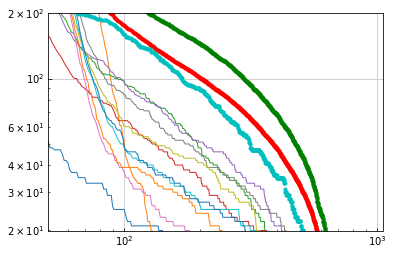

In [24]:
for chan in ampl.index:
    if ampl.loc[chan,'kch'] < 0.8:
        plt.plot(integral[chan], label=None)
    pass
plt.plot(integral.average,   'ro', label = 'aver', linewidth=2)
plt.plot(integral.average10, 'go', label = 'aver', linewidth=2)
plt.plot(integral['28'],   'co', label = 'aver', linewidth=2)
plt.xlim(50)
plt.ylim(20,200)
plt.xscale('log')
plt.yscale('log')
plt.grid()

## Результат

In [25]:
for chan in filters[:-1]:
    print("chan{:3s} k= {:.2f} +- {:.2f} +- {:.2f}".format(chan, 
            ampl.loc[chan,'kch'], 
            ampl.loc[chan,'delta10'], ampl.loc[chan,'delta200']) )

chan23  k= 0.36 +- 0.00 +- 0.14
chan26  k= 0.36 +- 0.08 +- 0.28
chan28  k= 0.93 +- 0.00 +- 0.40
chan31  k= 0.77 +- 0.00 +- 0.32
chan34  k= 0.77 +- 0.01 +- 0.41
chan37  k= 0.79 +- 0.00 +- 0.34


### Лучше всего пропускает черенковский свет фильтр, стоявший на канале 28, хуже всего - на каналах 23 и 26.
